<a href="https://colab.research.google.com/github/SirwaniViren/MSc-Gousto-Project/blob/main/initial_framework_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [112]:
import math
import numpy as np
import pandas as pd
import random
from collections import defaultdict
from random import randrange
import matplotlib.pyplot as plt

In [113]:
random.seed(42)

# Creating Synthetic Data
Here we have a few functions which are used to create synthetic data that we can later work with to allocate the orders to their respecitve factories.

In [114]:
def create_eligibility_dict(num_factories, num_items):
    items = list(range(100, 100 + num_items * 10, 10))
    eligibility_dict = {}

    # Start with a base number of items for the first factory
    num_eligible_items = random.randint(5, 15)

    for i in range(1, num_factories + 1):
        if i == num_factories:
            # Last factory gets all items
            eligibility_dict[f"F{i}"] = items
        else:
            eligibility_dict[f"F{i}"] = items[:num_eligible_items]
            # Randomly determine the number of additional items for the next factory
            num_eligible_items += random.randint(1, 10)
            # Ensure num_eligible_items does not exceed the total number of items
            num_eligible_items = min(num_eligible_items, num_items)

    return eligibility_dict

In [115]:
def create_factory_caps(num_factory, max_boxes):
    factory_caps = {}
    # Start with an initial capacity for the first factory
    cap = random.randint(1, max_boxes // 10)  # Starting with a base capacity

    for i in range(1, num_factory + 1):
        if i == num_factory:
            # Last factory gets infinite capacity
            factory_caps[f"F{i}"] = float('inf')
        else:
            factory_caps[f"F{i}"] = cap
            # Randomly increase the capacity for the next factory
            cap += random.randint(1, max_boxes // 10)
            # Ensure the capacity does not exceed max_boxes
            cap = min(cap, max_boxes)

    return factory_caps


def generate_total_boxes(factory_caps, min_extra_boxes, max_extra_boxes, lead_day):
    # Calculate total capacity excluding the infinite capacity
    finite_capacity = sum(cap for cap in factory_caps.values() if cap != float('inf'))

    # Add a random number of extra boxes to exceed the total capacity
    extra_boxes = random.randint(min_extra_boxes, max_extra_boxes)
    total_boxes = finite_capacity + extra_boxes

    # Determine the proportion of simulated orders based on the lead day
    if lead_day == 0:
        simulated_order_percentage = 0
    else:
        # Simulate orders percentage decreases linearly with lead day
        simulated_order_percentage = max(0, min(100, (lead_day / 18) * 100))

    # Calculate number of real and simulated orders
    num_simulated_orders = int(total_boxes * simulated_order_percentage / 100)
    num_real_orders = total_boxes - num_simulated_orders

    return num_real_orders, num_simulated_orders

In [116]:
def generate_order_list(start_order_id, order_count, order_type, items, max_items_per_order):
    orders = []
    order_id = start_order_id

    while order_count > 0:
        num_items_in_order = min(random.randint(1, max_items_per_order), len(items))
        order_items = random.sample(items, num_items_in_order)
        for item in order_items:
            orders.append({'order_id': order_id, 'item_id': item, 'order_type': order_type})
        order_count -= 1
        order_id += 1

    return orders, order_id

def generate_orders(total_real_orders, total_simulated_orders, num_items, max_items_per_order=5):
    items = list(range(100, 100 + num_items * 10, 10))
    current_order_id = 1

    # Generate real orders
    real_orders, current_order_id = generate_order_list(current_order_id, total_real_orders, 'real', items, max_items_per_order)

    # Generate simulated orders
    simulated_orders, _ = generate_order_list(current_order_id, total_simulated_orders, 'simulated', items, max_items_per_order)

    # Combine real and simulated orders
    all_orders = real_orders + simulated_orders

    # Convert to DataFrame
    orders_df = pd.DataFrame(all_orders)
    return orders_df

In [117]:
def compute_orders_eligibility(orders_df, eligibility_dict):
    orders_eligibility = []

    for order_id in orders_df['order_id'].unique():
        order_items = orders_df[orders_df['order_id'] == order_id]['item_id'].tolist()
        order_type = orders_df[orders_df['order_id'] == order_id]['order_type'].iloc[0]
        eligible_factories = []
        for factory, items in eligibility_dict.items():
            if all(item in items for item in order_items):
                eligible_factories.append(factory)
        orders_eligibility.append({'order_id': order_id, 'eligibility': eligible_factories, 'order_type': order_type})

    orders_eligibility_df = pd.DataFrame(orders_eligibility)
    return orders_eligibility_df

# Implement Functions to produce synthetic data

In [118]:
eligibility_dict = create_eligibility_dict(20, 100)
factory_caps = create_factory_caps(20, 100)

# print to check
print(list(eligibility_dict.items())[:10])
print("\n")
print(list(factory_caps.items())[:10])

[('F1', [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240]), ('F2', [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260]), ('F3', [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270]), ('F4', [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320]), ('F5', [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360]), ('F6', [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400]), ('F7', [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430]), ('F8', [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 2

In [119]:
real_orders_10, sim_orders_10 = generate_total_boxes(factory_caps, 1000, 2000, 10)
orders_10 = generate_orders(real_orders_10, sim_orders_10, 100, 5)
order_eligibility_10 = compute_orders_eligibility(orders_10, eligibility_dict)

print("\n")
print(orders_10.head())
print("\n")
print(order_eligibility_10.head())



   order_id  item_id order_type
0         1      870       real
1         1      430       real
2         1      150       real
3         2      780       real
4         2      250       real


   order_id                eligibility order_type
0         1            [F18, F19, F20]       real
1         2  [F16, F17, F18, F19, F20]       real
2         3            [F18, F19, F20]       real
3         4                 [F19, F20]       real
4         5            [F18, F19, F20]       real


In [120]:
real_orders_5, sim_orders_5 = generate_total_boxes(factory_caps, 1000, 2000, 5)
orders_5 = generate_orders(real_orders_5, sim_orders_5, 100, 5)
order_eligibility_5 = compute_orders_eligibility(orders_5, eligibility_dict)

print("\n")
print(orders_5.head())
print("\n")
print(order_eligibility_5.head())



   order_id  item_id order_type
0         1     1070       real
1         1      740       real
2         1      730       real
3         1     1030       real
4         2      290       real


   order_id                                        eligibility order_type
0         1                                              [F20]       real
1         2  [F4, F5, F6, F7, F8, F9, F10, F11, F12, F13, F...       real
2         3  [F9, F10, F11, F12, F13, F14, F15, F16, F17, F...       real
3         4  [F11, F12, F13, F14, F15, F16, F17, F18, F19, ...       real
4         5  [F7, F8, F9, F10, F11, F12, F13, F14, F15, F16...       real


In [121]:
real_orders_0, sim_orders_0 = generate_total_boxes(factory_caps, 1000, 2000, 0)
orders_0 = generate_orders(real_orders_0, sim_orders_0, 100, 5)
order_eligibility_0 = compute_orders_eligibility(orders_0, eligibility_dict)

print("\n")
print(orders_0.head())
print("\n")
print(order_eligibility_0.head())



   order_id  item_id order_type
0         1      360       real
1         1      270       real
2         1      380       real
3         1      990       real
4         2      760       real


   order_id                                        eligibility order_type
0         1                                         [F19, F20]       real
1         2                     [F15, F16, F17, F18, F19, F20]       real
2         3                                    [F18, F19, F20]       real
3         4  [F11, F12, F13, F14, F15, F16, F17, F18, F19, ...       real
4         5                                              [F20]       real


In [123]:
def allocate_orders(allocated_orders, allocated_order_eligibility, allocated_factory_caps):
    # Initialize columns
    allocated_orders['site'] = 'not_routed'
    allocated_order_eligibility['allocated'] = False

    # Iterate through each factory except the catch-all
    for factory in list(allocated_factory_caps.keys())[:-1]:
        cap = allocated_factory_caps[factory]

        # Get set S of unrouted orders eligible to the current factory
        eligible_orders = allocated_order_eligibility[(allocated_order_eligibility['allocated'] == False) &
                                                      (allocated_order_eligibility['eligibility'].apply(lambda i: factory in i))]

        if len(eligible_orders) < cap:
            raise ValueError(f'Not enough eligible orders for {factory}')
        else:
            for _ in range(cap):
                if len(eligible_orders) == 0:
                    break
                # Pick a random order from the eligible list
                selected_order = eligible_orders.sample(1).iloc[0]
                order_id = selected_order['order_id']

                # Allocate items in allocated_orders
                allocated_orders.loc[allocated_orders['order_id'] == order_id, 'site'] = factory

                # Mark the order as allocated in allocated_order_eligibility
                allocated_order_eligibility.loc[allocated_order_eligibility['order_id'] == order_id, 'allocated'] = True

                # Update the eligible_orders to exclude the allocated order
                eligible_orders = eligible_orders[eligible_orders['order_id'] != order_id]

    # Allocate remaining orders to catch-all
    catch_all_factory = list(allocated_factory_caps.keys())[-1]
    remaining_orders = allocated_order_eligibility[allocated_order_eligibility['allocated'] == False]
    for order_id in remaining_orders['order_id']:
        allocated_orders.loc[allocated_orders['order_id'] == order_id, 'site'] = catch_all_factory
        allocated_order_eligibility.loc[allocated_order_eligibility['order_id'] == order_id, 'allocated'] = True

    return allocated_orders

# Allocate orders to factories
We have a function which greedily allocates the orders to factories. By greedy we mean allocate orders to factory 1 until we have reached its capacity, then move on to factory 2, etc ...

In [124]:
allocation_10 = allocate_orders(orders_10.copy(), order_eligibility_10.copy(), factory_caps.copy())
allocation_5 = allocate_orders(orders_5.copy(), order_eligibility_5.copy(), factory_caps.copy())
allocation_0 = allocate_orders(orders_0.copy(), order_eligibility_0.copy(), factory_caps.copy())

In [125]:
print(allocation_10)

      order_id  item_id order_type site
0            1      870       real  F20
1            1      430       real  F20
2            1      150       real  F20
3            2      780       real  F16
4            2      250       real  F16
...        ...      ...        ...  ...
7546      2499      310  simulated  F16
7547      2500      360  simulated   F7
7548      2501      300  simulated  F20
7549      2501     1030  simulated  F20
7550      2501      470  simulated  F20

[7551 rows x 4 columns]


In [126]:
print(allocation_5)

      order_id  item_id order_type site
0            1     1070       real  F20
1            1      740       real  F20
2            1      730       real  F20
3            1     1030       real  F20
4            2      290       real   F4
...        ...      ...        ...  ...
8380      2858      430  simulated  F20
8381      2858      520  simulated  F20
8382      2858      800  simulated  F20
8383      2859      320  simulated   F8
8384      2859      150  simulated   F8

[8385 rows x 4 columns]


In [127]:
print(allocation_0)

      order_id  item_id order_type site
0            1      360       real  F20
1            1      270       real  F20
2            1      380       real  F20
3            1      990       real  F20
4            2      760       real  F17
...        ...      ...        ...  ...
7684      2570      600       real  F11
7685      2571     1050       real  F20
7686      2571      740       real  F20
7687      2571      990       real  F20
7688      2571      720       real  F20

[7689 rows x 4 columns]


# Plot factory Capacities for each lead day

In [128]:
def plot_factory_capacities(allocated_orders_df, factory_caps, lead_day):
    # Aggregate the orders by site and type
    real_orders_agg = allocated_orders_df[allocated_orders_df['order_type'] == 'real'].groupby('site')['order_id'].nunique()
    simulated_orders_agg = allocated_orders_df[allocated_orders_df['order_type'] == 'simulated'].groupby('site')['order_id'].nunique()

    # Ensure all sites are included in the aggregation and in the correct order
    all_sites = list(factory_caps.keys())
    real_orders_agg = real_orders_agg.reindex(all_sites, fill_value=0)
    simulated_orders_agg = simulated_orders_agg.reindex(all_sites, fill_value=0)

    # Prepare data for plotting
    sites = all_sites
    real_volumes = real_orders_agg[sites].values
    simulated_volumes = simulated_orders_agg[sites].values
    capacities = [factory_caps[site] if site in factory_caps else 0 for site in sites]

    # Plot the data
    fig, ax = plt.subplots(figsize=(15, 9))
    bar_width = 0.6

    bars_real = ax.bar(sites, real_volumes, bar_width, color='blue', label='Real Orders')
    bars_simulated = ax.bar(sites, simulated_volumes, bar_width, bottom=real_volumes, color='orange', label='Simulated Orders')

    # Add capacity lines and labels
    for site, cap in zip(sites, capacities):
        if cap == float('inf'):
            cap_label = 'inf'
        else:
            cap_label = str(cap)
            ax.plot([site, site], [0, cap], color='red', linestyle='--')
            ax.text(site, cap, cap_label, ha='center', va='bottom', color='red')

    ax.set_xlabel('Factories')
    ax.set_ylabel('Number of Orders')
    ax.set_title(f'Factory Capacities - Lead Day {lead_day}')
    ax.legend()

    plt.show()

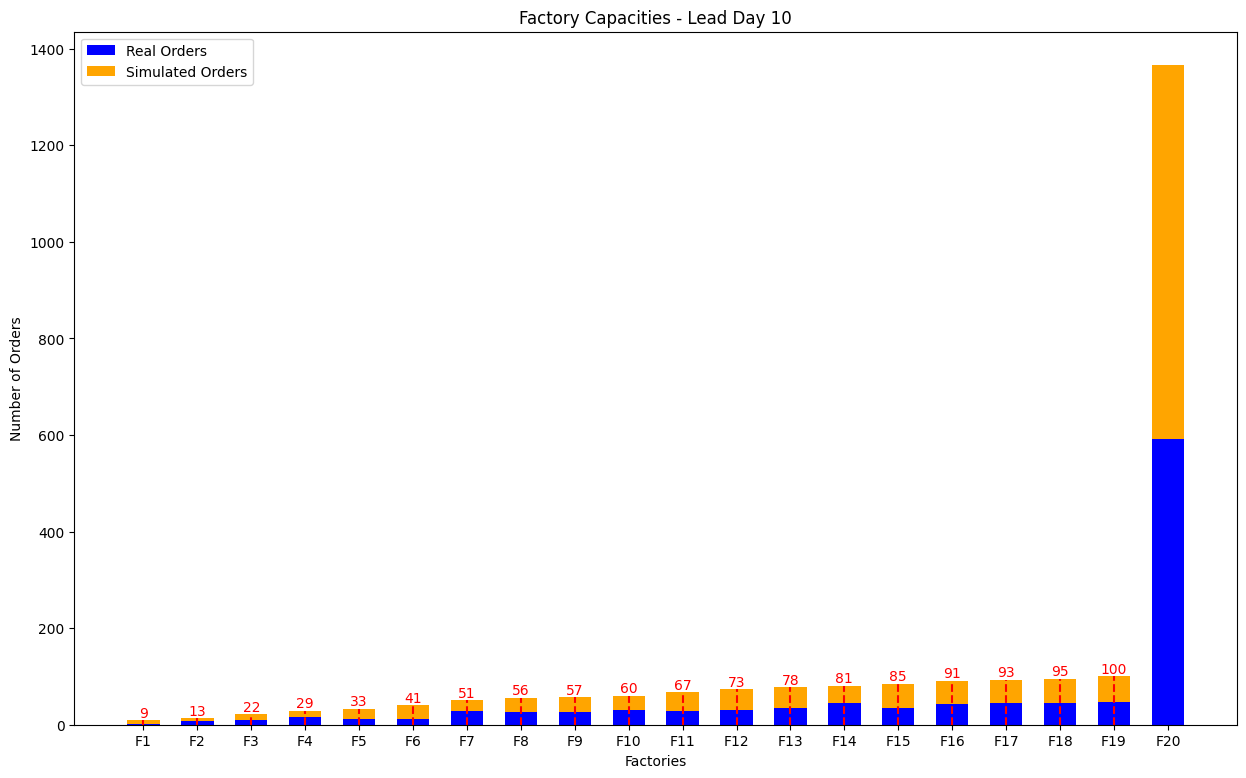

In [129]:
plot_factory_capacities(allocation_10.copy(), factory_caps.copy(), 10)

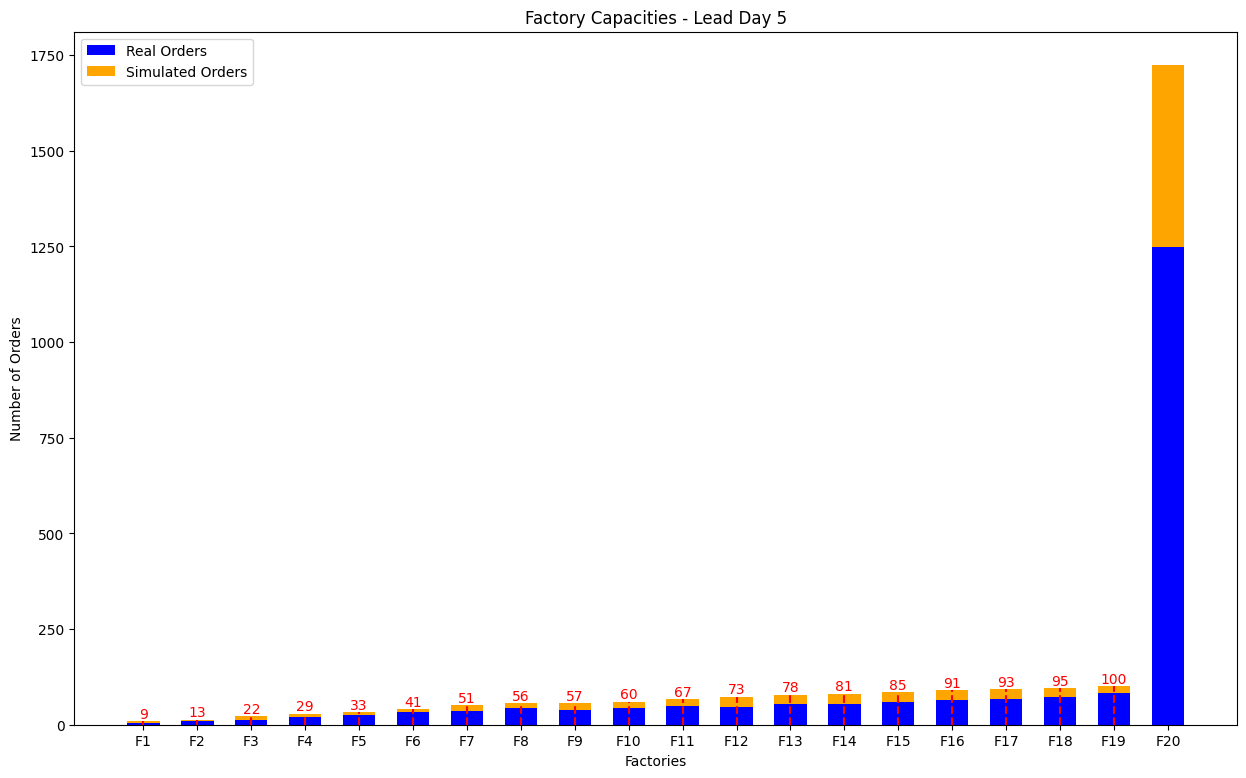

In [130]:
plot_factory_capacities(allocation_5.copy(), factory_caps.copy(), 5)

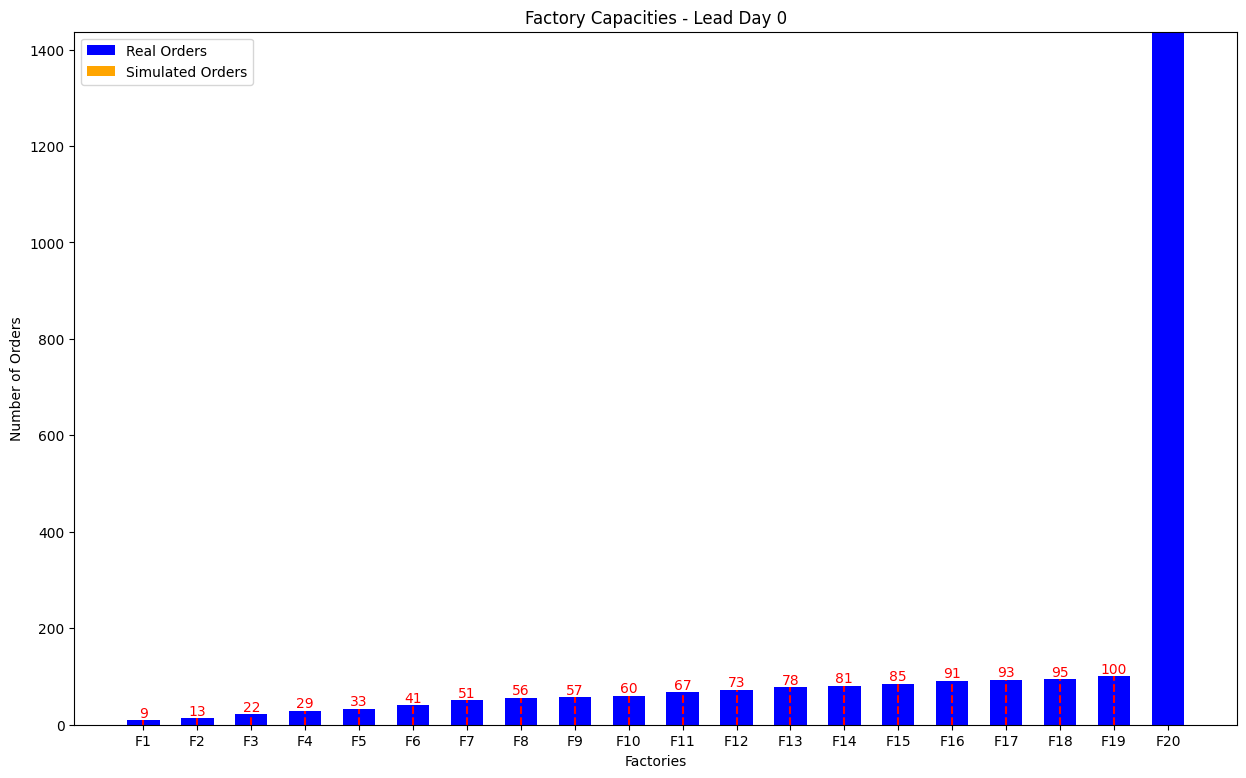

In [131]:
plot_factory_capacities(allocation_0.copy(), factory_caps, 0)

# Temporal plot to show split of simulated orders vs real orders

In [142]:
def split_order_type(df):
    real_orders = df[df['order_type'] == 'real']['order_id'].nunique()
    simulated_orders = df[df['order_type'] == 'simulated']['order_id'].nunique()
    return real_orders, simulated_orders

# Aggregate data for each lead day
real_orders_10, simulated_orders_10 = split_order_type(allocation_10.copy())
real_orders_5, simulated_orders_5 = split_order_type(allocation_5.copy())
real_orders_0, simulated_orders_0 = split_order_type(allocation_0.copy())

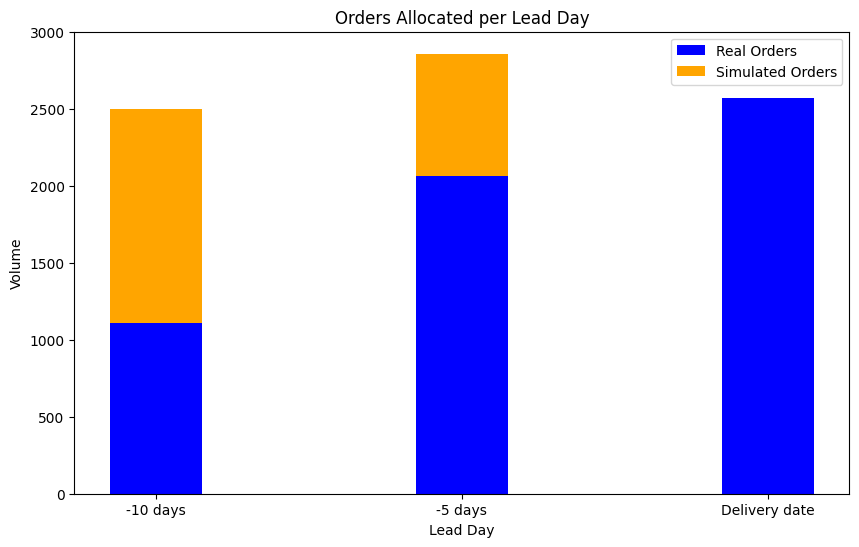

In [145]:
# Data for plotting
lead_days = ['-10 days', '-5 days', 'Delivery date']
real_orders = [real_orders_10, real_orders_5, real_orders_0]
simulated_orders = [simulated_orders_10, simulated_orders_5, simulated_orders_0]

# Plot the data
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.3
bars_real = ax.bar(lead_days, real_orders, bar_width, color='blue', label='Real Orders')
bars_simulated = ax.bar(lead_days, simulated_orders, bar_width, bottom=real_orders, color='orange', label='Simulated Orders')

# Add labels and title
ax.set_xlabel('Lead Day')
ax.set_ylabel('Volume')
ax.set_title('Orders Allocated per Lead Day')
ax.legend()

# Aggregate items and Merge allocation dataframes
We aggregate the allocated orders dataframes in terms of item_id and we the merge the aggregated dataframes depending on which lead days we would like to compare.

In [132]:
def aggregate_items(allocated_orders_df, day):
    lead_day = 'lead_' + str(day)
    aggregated_df = allocated_orders_df.groupby(['item_id', 'site']).size().reset_index(name=lead_day)
    return aggregated_df

In [134]:
aggregated_10 = aggregate_items(allocation_10, 10)
aggregated_5 = aggregate_items(allocation_5, 5)
aggregated_0 = aggregate_items(allocation_0, 0)

In [135]:
def merge_allocation(soft_df, hard_df, soft_num, hard_num):
    soft_day = 'lead_' + str(soft_num)
    hard_day = 'lead_' + str(hard_num)
    # Merge the two dataframes on 'item_id' and 'site'
    merged_df = pd.merge(soft_df, hard_df, on=['item_id', 'site'], how='outer')

    # Fill NaN values with zeros
    merged_df.fillna(0, inplace=True)

    # Ensure the integer type for lead_5 and lead_0 columns
    merged_df[soft_day] = merged_df[soft_day].astype(int)
    merged_df[hard_day] = merged_df[hard_day].astype(int)

    return merged_df

In [136]:
# Merge the dataframes and calculate the absolute error
merged_10_0_df = merge_allocation(aggregated_10, aggregated_0, soft_num=10, hard_num=0)
merged_5_0_df = merge_allocation(aggregated_5, aggregated_0, soft_num=5, hard_num=0)

# Calculate wmape site and wmape global

In [137]:
def calculate_wmape_site(merged_df, soft_col, hard_col):
    total_forecast = merged_df["lead_0"].sum()
    site_df = merged_df.copy()
    site_df['abs_error'] = (site_df[soft_col] - site_df[hard_col]).abs()

    # Calculate WMAPE_site
    wmape_site = site_df["abs_error"].sum() / total_forecast

    return site_df, wmape_site

In [138]:
def calculate_wmape_global(merged_df, soft_col, hard_col):
    total_forecast = merged_df["lead_0"].sum()
    global_df = merged_df.copy()
    global_df = global_df.groupby('item_id').sum().reset_index()
    global_df['abs_error'] = (global_df[soft_col] - global_df[hard_col]).abs()
    global_df = global_df.drop(['site'], axis=1, errors='ignore')

    # Calculate WMAPE_global
    wmape_global = global_df["abs_error"].sum() / total_forecast

    return global_df, wmape_global

In [139]:
site_10_0_df, wmape_10_0_site = calculate_wmape_site(merged_10_0_df, soft_col='lead_10', hard_col='lead_0')
global_10_0_df, wmape_10_0_global = calculate_wmape_global(merged_10_0_df, soft_col='lead_10', hard_col='lead_0')

In [140]:
site_5_0_df, wmape_5_0_site = calculate_wmape_site(merged_5_0_df, soft_col='lead_5', hard_col='lead_0')
global_5_0_df, wmape_5_0_global = calculate_wmape_global(merged_5_0_df, soft_col='lead_5', hard_col='lead_0')

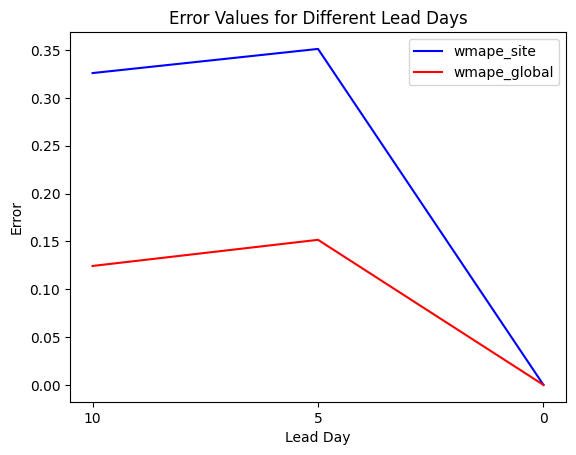

In [141]:
lead_days = [10, 5, 0]
wmape_site_values = [wmape_10_0_site, wmape_5_0_site, 0]
wmape_global_values = [wmape_10_0_global, wmape_5_0_global, 0]

# Plot the data
plt.plot(lead_days, wmape_site_values, linestyle='-', color='b', label="wmape_site")
plt.plot(lead_days, wmape_global_values, linestyle='-', color='r', label="wmape_global")
plt.xlabel('Lead Day')
plt.ylabel('Error')
plt.title('Error Values for Different Lead Days')
plt.xticks([10, 5, 0])
plt.legend()
plt.gca().invert_xaxis()  # Invert x-axis to have 0 at the end
plt.show()